In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import datetime as dt
import time
import random

In [ ]:
#处理300成分股------------------------------------------------------

In [2]:
comp_300=pd.read_csv('residuals.csv',parse_dates=['date'],dayfirst=True)
comp_300['month']=comp_300.date.apply(lambda x: dt.datetime.strftime(x,'%Y-%m'))
comp_300['day']=comp_300.date.apply(lambda x: dt.datetime.strftime(x,'%Y-%m-%d'))
# comp_300.drop(columns='date',inplace=True)
comp_300.drop(columns='residuals',inplace=True)
comp_300['monlast']=0
comp_300

,date,symbol,month,day,monlast
0,2005-04-29,000001.SZ,2005-04,2005-04-29,0
1,2005-04-29,000002.SZ,2005-04,2005-04-29,0
2,2005-04-29,000009.SZ,2005-04,2005-04-29,0
3,2005-04-29,000012.SZ,2005-04,2005-04-29,0
4,2005-04-29,000016.SZ,2005-04,2005-04-29,0
...,...,...,...,...,...
1112955,2020-07-31,603799.SH,2020-07,2020-07-31,0
1112956,2020-07-31,603833.SH,2020-07,2020-07-31,0
1112957,2020-07-31,603899.SH,2020-07,2020-07-31,0
1112958,2020-07-31,603986.SH,2020-07,2020-07-31,0


In [4]:
trade_day=comp_300.groupby('month').max()['day'].values
comp_300['monlast']=comp_300.day.apply(lambda x: 1 if x in trade_day else 0)
#记录每月底沪深300的成分股
comp_300=comp_300.loc[comp_300.monlast==1]
comp_300

,date,symbol,month,day,monlast
0,2005-04-29,000001.SZ,2005-04,2005-04-29,1
1,2005-04-29,000002.SZ,2005-04,2005-04-29,1
2,2005-04-29,000009.SZ,2005-04,2005-04-29,1
3,2005-04-29,000012.SZ,2005-04,2005-04-29,1
4,2005-04-29,000016.SZ,2005-04,2005-04-29,1
...,...,...,...,...,...
1112955,2020-07-31,603799.SH,2020-07,2020-07-31,1
1112956,2020-07-31,603833.SH,2020-07,2020-07-31,1
1112957,2020-07-31,603899.SH,2020-07,2020-07-31,1
1112958,2020-07-31,603986.SH,2020-07,2020-07-31,1


In [39]:
comp_300.to_csv('comp_hs300.csv')

In [ ]:
#整理全a股数据，从中选出需要的月度数据------------------------------------------------------

In [6]:
all_stk=pd.read_csv('all_stocks.csv',parse_dates=['date'],dayfirst=True)
all_stk=all_stk[all_stk['status']==0]
all_stk['return']=(all_stk.close-all_stk.pre_close)/all_stk.pre_close
all_stk['month']=all_stk.date.apply(lambda x: dt.datetime.strftime(x,'%Y-%m'))
all_stk

,date,symbol,pre_close,close,total_capital,pe,pb,status,return,month
0,2008-10-06,001872.SZ,32.6734,31.78460,7109207877,11.78000,2.978380,0.0,-0.027203,2008-10
1,2008-10-06,001914.SZ,11.9548,10.75930,1300574761,114.16600,0.910108,0.0,-0.100002,2008-10
2,2008-10-06,000001.SZ,430.3420,399.04900,33204253308,7.50776,1.807070,0.0,-0.072717,2008-10
3,2008-10-06,000002.SZ,692.9330,665.34300,67052566460,22.71210,2.291180,0.0,-0.039816,2008-10
4,2008-10-06,000008.SZ,10.2011,9.94796,289457107,685.39900,3.936650,0.0,-0.024815,2008-10
...,...,...,...,...,...,...,...,...,...,...
7482687,2020-07-31,601816.SH,6.2000,6.20000,304460204588,235.22400,1.660850,0.0,0.000000,2020-07
7482688,2020-07-31,601916.SH,4.3260,4.32600,83434789100,4.83837,0.755217,0.0,0.000000,2020-07
7482689,2020-07-31,603053.SH,15.3107,15.31070,13404461200,23.46150,3.746470,0.0,0.000000,2020-07
7482690,2020-07-31,603060.SH,48.3939,49.69250,10560088000,-71.53400,8.656680,0.0,0.026834,2020-07


In [11]:
#计算每只股票的月度收益率以及月底各财务指标
all_stk['return']=all_stk['return']+1
pbs=all_stk.groupby(['month','symbol'],as_index=False)['pb'].last()
pes=all_stk.groupby(['month','symbol'],as_index=False)['pe'].last()
caps=all_stk.groupby(['month','symbol'],as_index=False)['total_capital'].last()
closes=all_stk.groupby(['month','symbol'],as_index=False)['close'].last()
rts=all_stk.groupby(['month','symbol'],as_index=False)['return'].prod()
rts['pb']=pbs['pb']
rts['pe']=pes['pe']
rts['cap']=caps['total_capital']
rts['close']=closes['close']
rts['return']=rts['return']-1
rts

,month,symbol,return,pb,pe,cap,close
0,2008-10,000001.SZ,-0.271607,1.41458,5.87712,25992480588,313.43500
1,2008-10,000002.SZ,-0.099541,2.14867,21.29940,62165112619,623.95800
2,2008-10,000004.SZ,-0.324119,3.26934,-52.78820,225897280,9.75032
3,2008-10,000005.SZ,-0.262357,2.33133,129.13400,1773807198,33.96270
4,2008-10,000006.SZ,-0.208416,1.17622,6.38218,2003373885,65.41570
...,...,...,...,...,...,...,...
359049,2020-07,603992.SH,0.144109,3.97634,52.21740,7322440007,18.44990
359050,2020-07,603993.SH,0.198909,2.32882,53.01850,88860818795,14.97270
359051,2020-07,603996.SH,0.041474,-1.14500,-3.87795,678339000,3.47068
359052,2020-07,603997.SH,0.026205,1.57911,-37.54440,7199809828,11.79130


In [13]:
#选出全股里可能是hs300的股票
rts['state']=0
symbs=comp_300.symbol.unique()
rts['state']=rts['symbol'].apply(lambda x : 1 if x in symbs else 0 )
rts=rts[rts.state==1]
rts

,month,symbol,return,pb,pe,cap,close,state
0,2008-10,000001.SZ,-0.271607,1.41458,5.87712,25992480588,313.4350,1
1,2008-10,000002.SZ,-0.099541,2.14867,21.29940,62165112619,623.9580,1
6,2008-10,000008.SZ,-0.014891,3.97672,692.37500,292403236,10.0492,1
7,2008-10,000009.SZ,0.154321,2.28399,16.17730,3885149505,12.0899,1
10,2008-10,000012.SZ,-0.404785,1.61562,10.58650,6196258356,47.7997,1
...,...,...,...,...,...,...,...,...
359017,2020-07,603858.SH,0.045124,2.34663,26.88140,32717700283,57.9571,1
359027,2020-07,603885.SH,0.023077,1.78051,-9.31184,18304802102,27.5091,1
359032,2020-07,603899.SH,0.197254,13.67840,65.79090,60625942212,139.5100,1
359047,2020-07,603986.SH,-0.018693,20.03150,162.25800,108985720938,916.6070,1


In [15]:
#选出hs300的股票
t1=time.time()
rts['state']=rts.apply(find_comp,axis=1)
t2=time.time()
t2-t1

/Users/sexin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


449.9607479572296

In [16]:
rts=rts[rts.state==1]
rts.index=list(range(len(rts)))
rts.drop(columns='state',inplace=True)
rts

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,month,symbol,return,pb,pe,cap,close
0,2008-10,000001.SZ,-0.271607,1.414580,5.87712,25992480588,313.4350
1,2008-10,000002.SZ,-0.099541,2.148670,21.29940,62165112619,623.9580
2,2008-10,000009.SZ,0.154321,2.283990,16.17730,3885149505,12.0899
3,2008-10,000012.SZ,-0.404785,1.615620,10.58650,6196258356,47.7997
4,2008-10,000021.SZ,-0.261476,0.971109,11.63200,3254218528,23.4903
...,...,...,...,...,...,...,...
41949,2020-07,603799.SH,0.100359,5.679970,66.48420,48800342852,79.0255
41950,2020-07,603833.SH,0.091097,5.760860,-129.77100,52700568886,128.4070
41951,2020-07,603899.SH,0.197254,13.678400,65.79090,60625942212,139.5100
41952,2020-07,603986.SH,-0.018693,20.031500,162.25800,108985720938,916.6070


In [32]:
rts['pre_close']=0

/Users/sexin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
#计算近12个月来的累积收益率
for smb in rts.symbol.unique():
    cond=rts.symbol==smb
    rts.loc[cond,'pre_close']=rts.loc[cond,'close'].shift(12)
    rts.loc[cond,'pre_close']=(rts.loc[cond,'close']-rts.loc[cond,'pre_close'])/rts.loc[cond,'pre_close']

In [35]:
rts.rename(columns={'pre_close': 'cum_12months'},inplace=True)
rts.to_csv('stocks_hs300_monthly.csv')
rts

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,month,symbol,return,pb,pe,cap,close,cum_12months
0,2008-10,000001.SZ,-0.271607,1.414580,5.87712,25992480588,313.4350,NaN
1,2008-10,000002.SZ,-0.099541,2.148670,21.29940,62165112619,623.9580,NaN
2,2008-10,000009.SZ,0.154321,2.283990,16.17730,3885149505,12.0899,NaN
3,2008-10,000012.SZ,-0.404785,1.615620,10.58650,6196258356,47.7997,NaN
4,2008-10,000021.SZ,-0.261476,0.971109,11.63200,3254218528,23.4903,NaN
...,...,...,...,...,...,...,...,...
41949,2020-07,603799.SH,0.100359,5.679970,66.48420,48800342852,79.0255,0.828913
41950,2020-07,603833.SH,0.091097,5.760860,-129.77100,52700568886,128.4070,0.216240
41951,2020-07,603899.SH,0.197254,13.678400,65.79090,60625942212,139.5100,NaN
41952,2020-07,603986.SH,-0.018693,20.031500,162.25800,108985720938,916.6070,2.317926


In [14]:
def find_comp(df):
    if df['symbol'] in comp_300.loc[comp_300.month==df['month']].symbol.values:
        return 1
    else:
        return 0

In [ ]:
#投资组合的制作------------------------------------------------------

In [106]:
rts['pb_rank']=np.nan
rts['pe_rank']=np.nan
rts['cap_rank']=np.nan
rts['cum_rank']=np.nan
#double sort
rts['pb_rank2']=np.nan
rts['cap_rank2']=np.nan

/Users/sexin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sexin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sexin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [107]:
#按各财务指标高低把当月的股票样本分类，为构建多空组合做准备
for mon in rts.month.unique():
    cond=rts.month==mon
    rts.loc[cond,'pb_rank']=score(rts.loc[cond,'pb'],0.3)
    rts.loc[cond,'pe_rank']=score(rts.loc[cond,'pe'],0.3)
    rts.loc[cond,'cap_rank']=score(rts.loc[cond,'cap'],0.3)
    if mon>='2009-10':#全是nan时，qcut无法处理
        rts.loc[cond,'cum_rank']=score(rts.loc[cond,'cum_12months'],0.3)
    rts.loc[cond,'pb_rank2']=score(rts.loc[cond,'pb'],4)

In [111]:
for mon in rts.month.unique():
    for rk in rts.pb_rank2.unique():
        cond=(rts.month==mon)&(rts.pb_rank2==rk)
        rts.loc[cond,'cap_rank2']=score(rts.loc[cond,'cap'],5)
rts        

,month,symbol,return,pb,pe,cap,close,cum_12months,pb_rank,pe_rank,cap_rank,cum_rank,cap_rank2,pb_rank2
0,2008-10,000001.SZ,-0.271607,1.414580,5.87712,25992480588,313.4350,NaN,1,0,2,NaN,4,1
1,2008-10,000002.SZ,-0.099541,2.148670,21.29940,62165112619,623.9580,NaN,2,2,2,NaN,4,2
2,2008-10,000009.SZ,0.154321,2.283990,16.17730,3885149505,12.0899,NaN,2,1,0,NaN,0,2
3,2008-10,000012.SZ,-0.404785,1.615620,10.58650,6196258356,47.7997,NaN,1,1,1,NaN,2,1
4,2008-10,000021.SZ,-0.261476,0.971109,11.63200,3254218528,23.4903,NaN,0,1,0,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41949,2020-07,603799.SH,0.100359,5.679970,66.48420,48800342852,79.0255,0.828913,2,2,0,2,1,2
41950,2020-07,603833.SH,0.091097,5.760860,-129.77100,52700568886,128.4070,0.216240,2,0,1,1,0,3
41951,2020-07,603899.SH,0.197254,13.678400,65.79090,60625942212,139.5100,NaN,2,2,1,NaN,1,3
41952,2020-07,603986.SH,-0.018693,20.031500,162.25800,108985720938,916.6070,2.317926,2,2,1,2,2,3


In [113]:
#double sort之后得到的各资产等权月度收益率
ass_tmp=rts.groupby(['month','pb_rank2','cap_rank2'],as_index=False)['return'].mean()
ass_tmp

,month,pb_rank2,cap_rank2,return
0,2008-10,0,0,-0.345316
1,2008-10,0,1,-0.284138
2,2008-10,0,2,-0.286276
3,2008-10,0,3,-0.267699
4,2008-10,0,4,-0.318093
...,...,...,...,...
2835,2020-07,3,0,0.090843
2836,2020-07,3,1,0.082822
2837,2020-07,3,2,0.215044
2838,2020-07,3,3,0.210970


In [116]:
#将其转为更标准的数据块
assets=pd.DataFrame({})
assets['month']=pd.Series(ass_tmp['month'].unique())
for i in range(len(ass_tmp.pb_rank2.unique())):
    for j in range(len(ass_tmp.cap_rank2.unique())):
        asset0=ass_tmp.loc[(ass_tmp.pb_rank2==i)&(ass_tmp.cap_rank2==j)].sort_values('month')
        asset0.index=np.array(range(len(asset0)))
        assets['asset_'+f'{i}'+f'{j}']=asset0['return']
assets

,month,asset_00,asset_01,asset_02,asset_03,asset_04,asset_10,asset_11,asset_12,asset_13,...,asset_20,asset_21,asset_22,asset_23,asset_24,asset_30,asset_31,asset_32,asset_33,asset_34
0,2008-10,-0.345316,-0.284138,-0.286276,-0.267699,-0.318093,-0.326196,-0.309977,-0.340843,-0.254704,...,-0.244972,-0.343250,-0.204385,-0.278043,-0.223278,-0.245194,-0.245413,-0.206817,-0.233112,-0.195919
1,2008-11,0.153000,0.187512,0.116183,0.140414,0.125199,0.176324,0.146256,0.171723,0.136540,...,0.187874,0.180573,0.144541,0.167438,0.141088,0.179308,0.171450,0.127728,0.175638,0.190174
2,2008-12,-0.031167,-0.041311,-0.029980,-0.040327,-0.059233,-0.008461,0.012946,0.054399,0.010144,...,-0.001334,-0.002390,0.061663,0.034705,-0.024557,0.086965,0.052145,0.072593,0.044490,0.038381
3,2009-01,0.176830,0.166055,0.162119,0.097839,0.120898,0.127545,0.161682,0.168148,0.170996,...,0.176504,0.256406,0.231285,0.188381,0.107139,0.201027,0.166586,0.151783,0.138488,0.074467
4,2009-02,0.084940,0.076823,0.039746,0.033819,0.024497,0.042225,0.127309,0.143555,0.082420,...,0.083886,0.057553,0.043300,0.068398,0.039818,0.116240,0.131073,0.088704,0.111526,0.144465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2020-03,-0.078335,-0.044967,-0.059379,-0.039706,-0.040515,-0.117147,-0.058427,-0.025922,-0.056851,...,-0.082744,-0.076418,-0.121841,-0.110582,-0.075987,-0.117184,-0.065495,-0.035403,-0.024448,-0.003263
138,2020-04,-0.005262,0.000043,-0.019445,0.011757,0.008614,-0.024111,0.009987,-0.000080,0.012476,...,0.021516,0.067113,0.045202,0.111637,0.085435,0.099558,0.139043,0.105201,0.095435,0.111202
139,2020-05,-0.032738,-0.007055,-0.022055,-0.038758,-0.026574,-0.022165,-0.011363,-0.015404,-0.032887,...,0.026439,-0.026594,0.007046,-0.031060,-0.016155,0.039888,0.025037,0.031143,0.015734,0.022876
140,2020-06,0.005989,0.017423,0.018574,0.007217,-0.008232,0.019505,0.065664,0.066411,0.084443,...,-0.000605,0.079712,0.079937,0.097384,0.114405,0.124293,0.114669,0.212748,0.202846,0.210604


In [119]:
#计算各资产的累积收益率
for col in assets.columns[1:].values:
    assets[col]=assets[col]+1
    assets['cum_'+f'{col}']=assets[col].cumprod()#累计收益率
    assets[col]=assets[col]-1
assets

,month,asset_00,asset_01,asset_02,asset_03,asset_04,asset_10,asset_11,asset_12,asset_13,...,cum_asset_20,cum_asset_21,cum_asset_22,cum_asset_23,cum_asset_24,cum_asset_30,cum_asset_31,cum_asset_32,cum_asset_33,cum_asset_34
0,2008-10,-0.345316,-0.284138,-0.286276,-0.267699,-0.318093,-0.326196,-0.309977,-0.340843,-0.254704,...,0.755028,0.656750,0.795615,0.721957,0.776722,0.754806,0.754587,0.793183,0.766888,0.804081
1,2008-11,0.153000,0.187512,0.116183,0.140414,0.125199,0.176324,0.146256,0.171723,0.136540,...,0.896878,0.775341,0.910614,0.842840,0.886308,0.890149,0.883961,0.894495,0.901583,0.956995
2,2008-12,-0.031167,-0.041311,-0.029980,-0.040327,-0.059233,-0.008461,0.012946,0.054399,0.010144,...,0.895682,0.773489,0.966766,0.872091,0.864543,0.967561,0.930055,0.959429,0.941694,0.993726
3,2009-01,0.176830,0.166055,0.162119,0.097839,0.120898,0.127545,0.161682,0.168148,0.170996,...,1.053773,0.971816,1.190364,1.036377,0.957169,1.162067,1.084989,1.105054,1.072108,1.067726
4,2009-02,0.084940,0.076823,0.039746,0.033819,0.024497,0.042225,0.127309,0.143555,0.082420,...,1.142170,1.027746,1.241907,1.107263,0.995281,1.297146,1.227201,1.203076,1.191676,1.221976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2020-03,-0.078335,-0.044967,-0.059379,-0.039706,-0.040515,-0.117147,-0.058427,-0.025922,-0.056851,...,0.148443,0.772077,3.027346,8.001652,16.148059,0.804262,8.815186,17.224618,61.466783,79.292173
138,2020-04,-0.005262,0.000043,-0.019445,0.011757,0.008614,-0.024111,0.009987,-0.000080,0.012476,...,0.151636,0.823893,3.164189,8.894933,17.527669,0.884333,10.040879,19.036661,67.332843,88.109631
139,2020-05,-0.032738,-0.007055,-0.022055,-0.038758,-0.026574,-0.022165,-0.011363,-0.015404,-0.032887,...,0.155646,0.801983,3.186485,8.618654,17.244517,0.919607,10.292276,19.629511,68.392280,90.125205
140,2020-06,0.005989,0.017423,0.018574,0.007217,-0.008232,0.019505,0.065664,0.066411,0.084443,...,0.155551,0.865910,3.441204,9.457969,19.217374,1.033907,11.472484,23.805654,82.265414,109.105903


<AxesSubplot:>

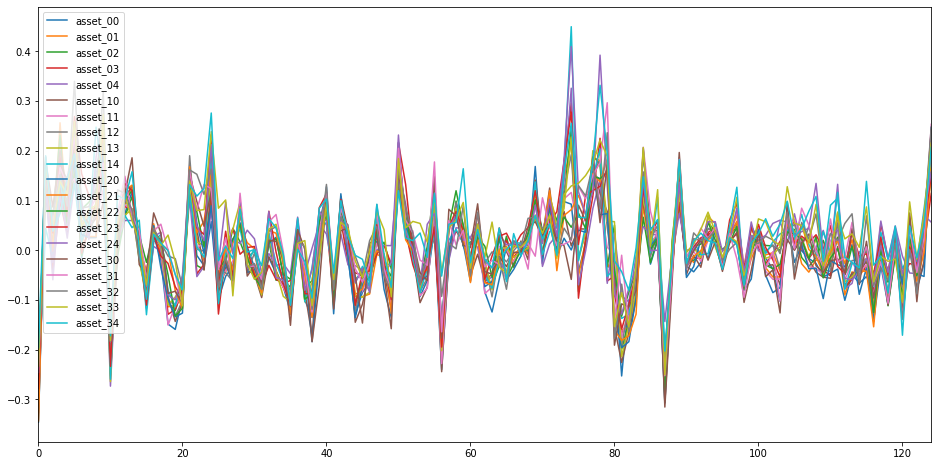

In [123]:
assets.iloc[:-17][assets.columns[1:21]].plot(figsize=(16,8),legend=True)

<AxesSubplot:>

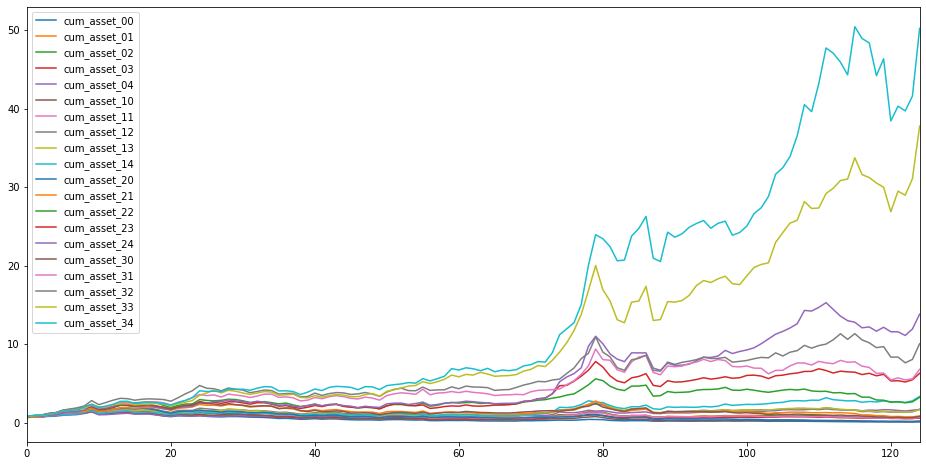

In [121]:
assets.iloc[:-17][assets.columns[21:]].plot(figsize=(16,8),legend=True)

In [124]:
assets.to_csv('assets_hs300_monthly.csv')

In [78]:
def score(x,num):
    if num>=1:
        return pd.qcut(x, num, labels=list(range(num)))
    if num<1:
        return pd.qcut(x, [0,num,1-num,1], labels=list(range(3)))

In [ ]:
#处理fama因子数据------------------------------------------------------

In [142]:
fcts=['pb_rank','pe_rank','cap_rank','cum_rank']
for col in fcts:
    fct_tmp=rts.groupby(['month',col],as_index=False)['return'].mean()
    fct_tmp[col]=(fct_tmp[col]-1)/2*fct_tmp['return']
    fct_tmp=fct_tmp.groupby(['month'],as_index=False)[col].sum()
    if col==fcts[0]:
        fct_rts=fct_tmp
    else:
        fct_rts = pd.merge(fct_rts, fct_tmp, on='month',how='outer')
fct_rts.rename(columns={'pb_rank':'hml','pe_rank':'rmw','cap_rank':'smb','cum_rank':'umd'},inplace=True)
fct_rts

,month,hml,rmw,smb,umd
0,2008-10,0.036195,0.047496,0.029039,NaN
1,2008-11,0.011115,0.036908,-0.019375,NaN
2,2008-12,0.040585,0.004486,-0.005569,NaN
3,2009-01,0.002140,-0.004564,-0.022841,NaN
4,2009-02,0.023105,0.037265,-0.005650,NaN
...,...,...,...,...,...
137,2020-03,-0.004835,-0.005343,0.019841,0.023865
138,2020-04,0.051741,0.022596,0.023469,0.056307
139,2020-05,0.025204,0.007592,-0.003178,0.012803
140,2020-06,0.074885,0.041276,0.037690,0.085713


In [143]:
#计算因子的累积收益率
for col in fct_rts.columns[1:].values:
    fct_rts[col]=fct_rts[col]+1
    fct_rts['cum_'+f'{col}']=fct_rts[col].cumprod()#累计收益率
    fct_rts[col]=fct_rts[col]-1
fct_rts

,month,hml,rmw,smb,umd,cum_hml,cum_rmw,cum_smb,cum_umd
0,2008-10,0.036195,0.047496,0.029039,NaN,1.036195,1.047496,1.029039,NaN
1,2008-11,0.011115,0.036908,-0.019375,NaN,1.047713,1.086157,1.009101,NaN
2,2008-12,0.040585,0.004486,-0.005569,NaN,1.090234,1.091030,1.003481,NaN
3,2009-01,0.002140,-0.004564,-0.022841,NaN,1.092567,1.086051,0.980561,NaN
4,2009-02,0.023105,0.037265,-0.005650,NaN,1.117811,1.126523,0.975021,NaN
...,...,...,...,...,...,...,...,...,...
137,2020-03,-0.004835,-0.005343,0.019841,0.023865,4.687032,2.046212,4.443535,29.361133
138,2020-04,0.051741,0.022596,0.023469,0.056307,4.929543,2.092448,4.547819,31.014359
139,2020-05,0.025204,0.007592,-0.003178,0.012803,5.053789,2.108333,4.533366,31.411438
140,2020-06,0.074885,0.041276,0.037690,0.085713,5.432240,2.195357,4.704230,34.103813


<AxesSubplot:>

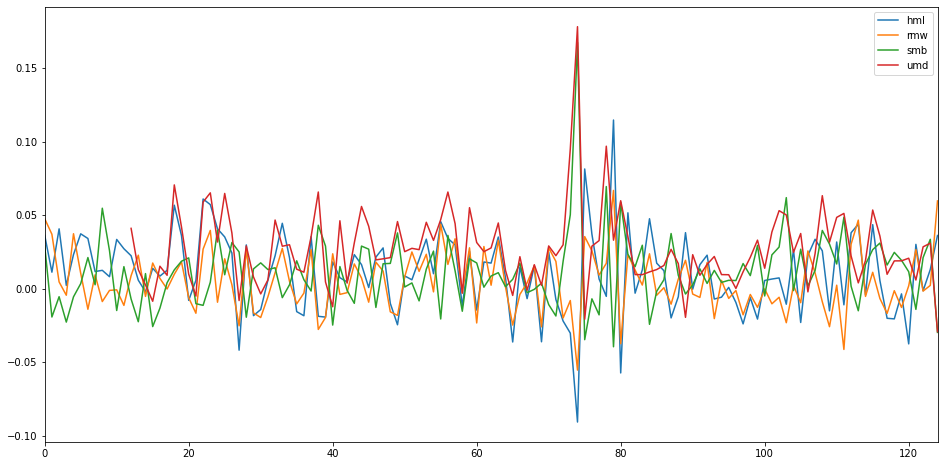

In [145]:
fct_rts.iloc[:-17][fct_rts.columns[1:5]].plot(figsize=(16,8),legend=True)

<AxesSubplot:>

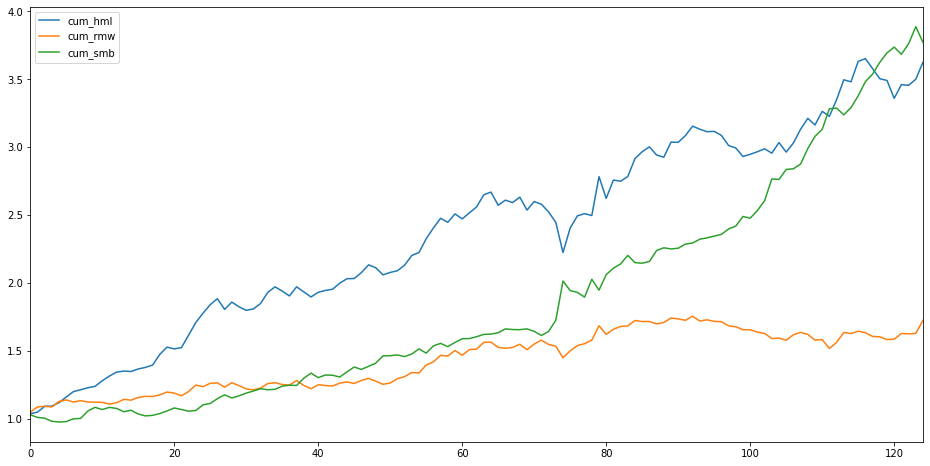

In [147]:
fct_rts.iloc[:-17][fct_rts.columns[5:-1]].plot(figsize=(16,8),legend=True)

In [148]:
fct_rts.to_csv('fama_fcts.csv')

In [ ]:
#处理barra因子数据------------------------------------------------------

In [154]:
#读入原始barra因子数据
barra=pd.read_csv('factor_return.csv',parse_dates=['date'],dayfirst=True).loc[1:]#去掉不全的2005-04
barra

,date,country,beta,value,growth,momentum,size,leverage,earnings,liquidity,...,materials,industrials,consumer_discretionary,consumer_staples,health_care,financials,information,telecom,utilities,real_estate
1,2005-05-09,-0.025235,-0.004499,-0.005717,-0.001788,-0.006616,0.007494,-0.004329,0.004410,-0.001481,...,0.003580,-0.009070,0.000731,0.000675,0.010969,-0.000509,-0.009816,0.013683,0.009606,-0.011932
2,2005-05-10,0.004032,0.002804,0.002563,0.002258,-0.002535,0.005936,-0.000957,0.004053,0.002004,...,-0.004257,0.001177,0.000426,0.003335,-0.003052,0.013671,0.011296,-0.000855,-0.011818,0.012132
3,2005-05-11,-0.010895,-0.000960,-0.001781,-0.003284,-0.009055,0.001012,-0.000022,0.002422,-0.003148,...,0.001097,-0.002427,0.000135,0.002829,-0.005701,-0.004890,0.010643,0.009250,-0.002147,0.006721
4,2005-05-12,-0.016432,0.000839,-0.003444,0.001341,-0.006721,-0.005451,0.003571,-0.002469,-0.002494,...,0.003332,0.002551,0.007067,0.004407,-0.002533,-0.013549,0.000641,0.012797,-0.004998,-0.004274
5,2005-05-13,0.001933,-0.000605,-0.000393,-0.000145,-0.004084,-0.003465,0.000426,-0.001035,-0.000214,...,0.002949,0.002588,0.005697,-0.002287,0.009783,-0.002832,0.015878,-0.000387,-0.000587,-0.027532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3705,2020-07-27,0.004555,-0.000476,-0.000409,-0.000213,-0.002681,0.000353,-0.003608,-0.003580,-0.001963,...,0.017771,-0.010784,-0.002236,0.002758,0.015389,-0.001808,0.004363,-0.005979,0.004233,-0.013638
3706,2020-07-28,0.007811,0.000388,-0.002822,-0.001011,0.003851,-0.001719,-0.001025,0.004177,-0.000618,...,0.002986,0.003628,-0.010187,0.020842,-0.008248,-0.004053,-0.004684,0.003581,-0.001369,-0.005673
3707,2020-07-29,0.023977,0.006798,0.000213,0.000407,0.002901,-0.001743,0.001286,-0.002650,0.000186,...,-0.014344,-0.005263,0.010671,-0.016977,0.010219,0.007582,0.001463,-0.003858,-0.009084,-0.008793
3708,2020-07-30,-0.004785,-0.001547,0.003246,0.001035,0.000051,-0.001495,-0.002833,0.000631,-0.000858,...,0.001165,0.004948,-0.003643,0.014256,0.011806,-0.004906,-0.006763,-0.015555,0.002601,0.004908


In [156]:
barra['date']=barra.date.apply(lambda x: dt.datetime.strftime(x,'%Y-%m'))
barra.rename(columns={'date': 'month'},inplace=True)
#计算因子收益率的月频
barra=monthly_fct(barra)
barra

,month,country,beta,value,growth,momentum,size,leverage,earnings,liquidity,...,cum_materials,cum_industrials,cum_consumer_discretionary,cum_consumer_staples,cum_health_care,cum_financials,cum_information,cum_telecom,cum_utilities,cum_real_estate
0,2005-05,-0.084011,-0.016308,0.000516,-0.010810,-0.058812,-0.014709,0.001442,0.008021,-0.001592,...,1.011321,1.004651,1.030788,1.031867,1.018347,0.991784,1.044654,1.000316,0.969476,0.992112
1,2005-06,0.008757,-0.011878,-0.005379,-0.001064,0.014213,0.015391,-0.004848,-0.002003,0.005126,...,1.006788,0.986874,1.036704,1.034877,0.985456,1.016394,1.034962,1.022893,1.003450,1.001367
2,2005-07,-0.011751,-0.002583,0.002416,0.009663,0.011548,0.050924,-0.007994,0.004136,0.017468,...,0.993993,0.983139,1.025879,1.040967,0.989937,1.071645,1.015991,1.035498,1.016668,1.049670
3,2005-08,0.055754,0.034267,0.004633,0.009446,-0.027481,-0.017377,0.005495,-0.013354,-0.023230,...,0.976569,0.979152,1.017507,1.061475,1.003011,1.060970,1.036651,1.064404,1.030283,1.047703
4,2005-09,-0.002458,-0.002978,-0.020718,0.016477,-0.009207,-0.022967,-0.000758,-0.000779,-0.010510,...,0.990022,0.970938,1.014291,1.028896,0.965998,1.063196,0.996227,1.038421,1.025623,1.081467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2020-03,-0.065049,-0.026713,0.014088,-0.001401,0.006967,-0.012770,-0.008808,-0.005013,-0.010256,...,0.600697,0.743090,1.196283,3.919580,1.975512,0.858312,1.019875,1.255073,0.483421,1.845133
179,2020-04,0.044611,-0.005549,-0.009801,0.016960,0.020920,0.001306,-0.003770,-0.005884,0.005191,...,0.592163,0.759885,1.183638,3.974717,2.037443,0.848389,1.030453,1.276144,0.478479,1.843362
180,2020-05,-0.011744,-0.007021,-0.005399,0.003368,0.004459,-0.005367,-0.000623,-0.012987,-0.000934,...,0.600602,0.746474,1.225648,4.091398,2.092207,0.840603,1.002438,1.278420,0.472235,1.822181
181,2020-06,0.067942,0.041438,-0.000674,-0.001174,0.017271,0.008502,0.009416,-0.009755,-0.017208,...,0.592377,0.721958,1.205712,4.097380,2.272653,0.827220,1.063403,1.313328,0.477775,1.810516


<AxesSubplot:>

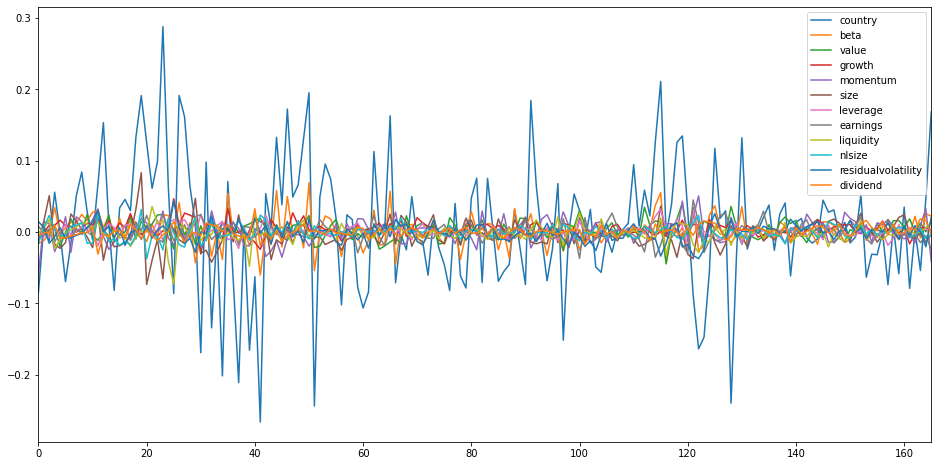

In [159]:
barra.iloc[:-17][barra.columns[1:13]].plot(figsize=(16,8),legend=True)

<AxesSubplot:>

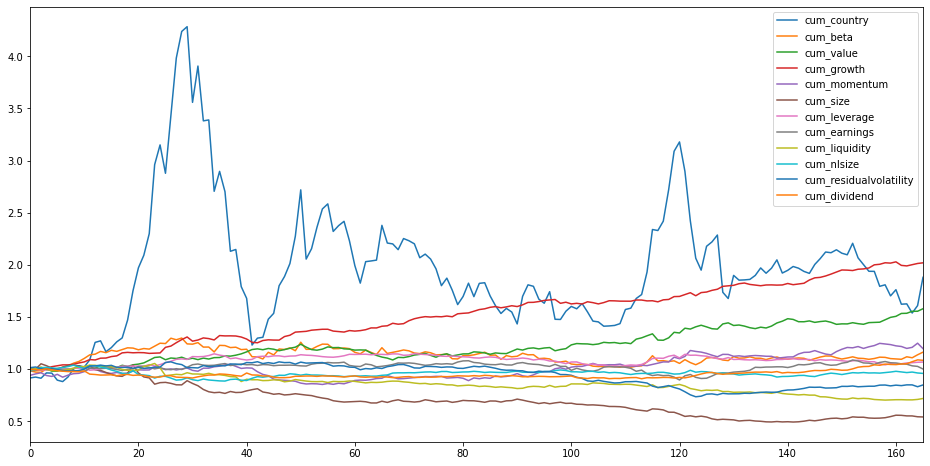

In [160]:
barra.iloc[:-17][barra.columns[25:37]].plot(figsize=(16,8),legend=True)

In [163]:
factors = pd.merge(barra,fct_rts, on='month',how='outer')
factors.to_csv('factors_hs300.csv')
factors

,month,country,beta,value,growth,momentum,size,leverage,earnings,liquidity,...,cum_utilities,cum_real_estate,hml,rmw,smb,umd,cum_hml,cum_rmw,cum_smb,cum_umd
0,2005-05,-0.084011,-0.016308,0.000516,-0.010810,-0.058812,-0.014709,0.001442,0.008021,-0.001592,...,0.969476,0.992112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-06,0.008757,-0.011878,-0.005379,-0.001064,0.014213,0.015391,-0.004848,-0.002003,0.005126,...,1.003450,1.001367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-07,-0.011751,-0.002583,0.002416,0.009663,0.011548,0.050924,-0.007994,0.004136,0.017468,...,1.016668,1.049670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-08,0.055754,0.034267,0.004633,0.009446,-0.027481,-0.017377,0.005495,-0.013354,-0.023230,...,1.030283,1.047703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-09,-0.002458,-0.002978,-0.020718,0.016477,-0.009207,-0.022967,-0.000758,-0.000779,-0.010510,...,1.025623,1.081467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2020-03,-0.065049,-0.026713,0.014088,-0.001401,0.006967,-0.012770,-0.008808,-0.005013,-0.010256,...,0.483421,1.845133,-0.004835,-0.005343,0.019841,0.023865,4.687032,2.046212,4.443535,29.361133
179,2020-04,0.044611,-0.005549,-0.009801,0.016960,0.020920,0.001306,-0.003770,-0.005884,0.005191,...,0.478479,1.843362,0.051741,0.022596,0.023469,0.056307,4.929543,2.092448,4.547819,31.014359
180,2020-05,-0.011744,-0.007021,-0.005399,0.003368,0.004459,-0.005367,-0.000623,-0.012987,-0.000934,...,0.472235,1.822181,0.025204,0.007592,-0.003178,0.012803,5.053789,2.108333,4.533366,31.411438
181,2020-06,0.067942,0.041438,-0.000674,-0.001174,0.017271,0.008502,0.009416,-0.009755,-0.017208,...,0.477775,1.810516,0.074885,0.041276,0.037690,0.085713,5.432240,2.195357,4.704230,34.103813


In [155]:
def monthly_fct(fct_df): 
    df=fct_df.copy()
    for col in df.columns[1:].values:
        df[col]=df[col].apply(lambda x : 1+x)
        
    rlt=df.groupby('month',as_index=False).prod()
    
    for col in df.columns[1:].values:  
        rlt['cum_'+f'{col}']=rlt[col].cumprod()#累计收益率
        rlt[col]=rlt[col].apply(lambda x : x-1)#月收益率
#     for col in df.columns[1:].values:  
#         rlt['demean_'+f'{col}']=rlt[col]-rlt[col].mean()
    return rlt